In [14]:
import torch
import torchvision
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [15]:
def load_and_preprocess_data(file_path):
    # Load data from the CSV file
    data = pd.read_csv(file_path, header=None)
    labels = data.iloc[:, 0].values
    features = data.iloc[:, 1:].values
    
    # Preprocess the features using StandardScaler
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    '''# Step 3: Initialize PCA object with desired number of components
    num_components = 8  # Set the desired number of components
    pca = PCA(n_components=num_components)

    # Fit PCA model to the scaled data
    pca.fit(features_scaled)

    #Transform the data using the fitted PCA model
    features_scaled = pca.transform(features_scaled)'''
    
    # Encode categorical labels into numerical form
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    # Convert features and labels to torch tensors
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
    #features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels_encoded, dtype=torch.long)
    
    return features_tensor, labels_tensor#, scaler, pca

In [16]:
train_features, train_labels = load_and_preprocess_data('lbp_features_train.csv')#, scaler, train_pca

test_features, test_labels = load_and_preprocess_data('lbp_features_test.csv')#, scaler, test_pca

features = torch.cat((train_features, test_features), dim=0)
labels = torch.cat((train_labels, test_labels), dim=0)


In [17]:
# Define the MLP model
input_size = features.shape[1]

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


model = MLP(input_size)
model.load_state_dict(torch.load("MLP_state_dict.pth"))
model = model.to(device)

In [18]:
model.eval() 
y_true = []
y_pred = []


with torch.no_grad():
    features = features.to(device)
    labels = labels.to(device)
    outputs = model(features)
    _, predicted = torch.max(outputs.data, 1)

    y_true.extend(labels.tolist()) 
    y_pred.extend(predicted.tolist())

In [19]:
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Precision: 0.8418
Recall: 0.8377
F1 Score: 0.8368


In [20]:
class_names = ['benign', 'malignant']  # Replace with your actual class names

decoded_true_labels = [class_names[label] for label in y_true]
decoded_pred_labels = [class_names[label] for label in y_pred]

In [21]:
confusion_mat = confusion_matrix(decoded_true_labels, decoded_pred_labels)
print("Confusion Matrix:")
print(confusion_mat)


Confusion Matrix:
[[4953  547]
 [1174 3931]]


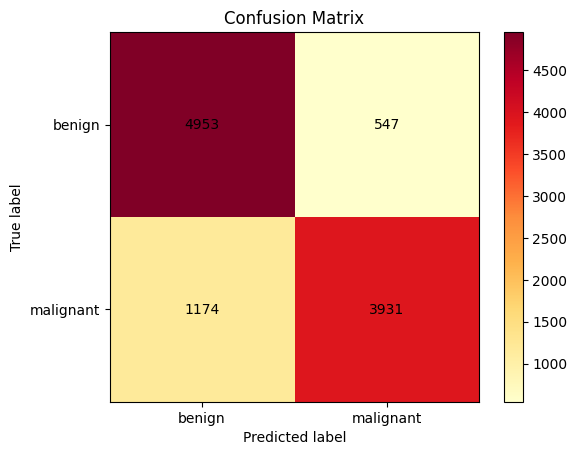

In [22]:
fig, ax = plt.subplots()
im = ax.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.YlOrRd)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(confusion_mat.shape[1]),
       yticks=np.arange(confusion_mat.shape[0]),
       xticklabels=class_names, yticklabels=class_names,
       xlabel='Predicted label',
       ylabel='True label',
       title='Confusion Matrix')

# Loop over data dimensions and create text annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, confusion_mat[i, j],
                       ha="center", va="center", color="black")

plt.show()
